In [ ]:
from sklearn.datasets import load_breast_cancer, load_digits, load_iris, load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from src.tabpfn import TabPFNClassifier

import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pandas as pd
from tqdm import tqdm


## Experiment on load breast_cancer dataset

In [2]:
# Load data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = TabPFNClassifier()  # Uses TabPFN 2.5 weights, finetuned on real data.
clf.fit(X_train, y_train)

# Predict probabilities
prediction_probabilities = clf.predict_proba(X_test)
# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

Inverse transforming predicted labels to original encoding.
Accuracy 0.9824561403508771


In [3]:
# test fit with differentiable inputs and outputs by converting the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
clf = TabPFNClassifier()
clf.fit(X_train_tensor, y_train_tensor)

prediction_probabilities_tensor = clf.predict_proba(X_test_tensor)
predictions_tensor = clf.predict(X_test_tensor)
print("Accuracy with tensors", accuracy_score(y_test_tensor, predictions_tensor))

Inverse transforming predicted labels to original encoding.
Accuracy with tensors 0.9824561403508771


In [5]:
# test fit with differentiable inputs and outputs by converting the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
clf = TabPFNClassifier(differentiable_input=True)
clf.fit_with_differentiable_input(X_train_tensor, y_train_tensor)

prediction_probabilities_tensor = clf.predict_proba(X_test_tensor)
predictions_tensor = clf.predict_logits(X_test_tensor)
#print("Accuracy with differentiable input", accuracy_score(y_test_tensor, predictions_tensor))

TabPFNCUDAOutOfMemoryError: CUDA out of memory with 285 test samples.

Solution: Split your test data into smaller batches:

    batch_size = 1000  # depends on hardware
    predictions = []
    for i in range(0, len(X_test), batch_size):
        batch = model.predict_proba(X_test[i:i + batch_size])
        predictions.append(batch)
    predictions = np.vstack(predictions)

Original error: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 44.39 GiB of which 10.00 MiB is free. Process 2548391 has 9.87 GiB memory in use. Including non-PyTorch memory, this process has 34.50 GiB memory in use. Of the allocated memory 33.99 GiB is allocated by PyTorch, and 10.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

  5%|▌         | 1/20 [00:00<00:04,  4.20it/s]

Completed 1/20 experiments.
Experiment 1, Accuracy: 0.9824561403508771


 10%|█         | 2/20 [00:00<00:04,  4.03it/s]

Completed 2/20 experiments.
Experiment 2, Accuracy: 0.9859649122807017


 15%|█▌        | 3/20 [00:00<00:03,  4.27it/s]

Completed 3/20 experiments.
Experiment 3, Accuracy: 0.9824561403508771


 20%|██        | 4/20 [00:00<00:03,  4.24it/s]

Completed 4/20 experiments.
Experiment 4, Accuracy: 0.9859649122807017


 25%|██▌       | 5/20 [00:01<00:03,  4.12it/s]

Completed 5/20 experiments.
Experiment 5, Accuracy: 0.9859649122807017


 30%|███       | 6/20 [00:01<00:03,  4.27it/s]

Completed 6/20 experiments.
Experiment 6, Accuracy: 0.9824561403508771


 35%|███▌      | 7/20 [00:01<00:02,  4.36it/s]

Completed 7/20 experiments.
Experiment 7, Accuracy: 0.9789473684210527


 40%|████      | 8/20 [00:01<00:02,  4.37it/s]

Completed 8/20 experiments.
Experiment 8, Accuracy: 0.9789473684210527


 45%|████▌     | 9/20 [00:02<00:02,  4.29it/s]

Completed 9/20 experiments.
Experiment 9, Accuracy: 0.9859649122807017


 50%|█████     | 10/20 [00:02<00:02,  4.34it/s]

Completed 10/20 experiments.
Experiment 10, Accuracy: 0.9859649122807017


 55%|█████▌    | 11/20 [00:02<00:02,  4.36it/s]

Completed 11/20 experiments.
Experiment 11, Accuracy: 0.9824561403508771


 60%|██████    | 12/20 [00:02<00:01,  4.34it/s]

Completed 12/20 experiments.
Experiment 12, Accuracy: 0.9859649122807017


 65%|██████▌   | 13/20 [00:03<00:01,  4.37it/s]

Completed 13/20 experiments.
Experiment 13, Accuracy: 0.9824561403508771


 70%|███████   | 14/20 [00:03<00:01,  4.45it/s]

Completed 14/20 experiments.
Experiment 14, Accuracy: 0.9859649122807017


 75%|███████▌  | 15/20 [00:03<00:01,  4.54it/s]

Completed 15/20 experiments.
Experiment 15, Accuracy: 0.9894736842105263


 80%|████████  | 16/20 [00:03<00:00,  4.57it/s]

Completed 16/20 experiments.
Experiment 16, Accuracy: 0.9824561403508771


 85%|████████▌ | 17/20 [00:03<00:00,  4.60it/s]

Completed 17/20 experiments.
Experiment 17, Accuracy: 0.9859649122807017


 90%|█████████ | 18/20 [00:04<00:00,  4.64it/s]

Completed 18/20 experiments.
Experiment 18, Accuracy: 0.9859649122807017


 95%|█████████▌| 19/20 [00:04<00:00,  4.67it/s]

Completed 19/20 experiments.
Experiment 19, Accuracy: 0.9754385964912281


100%|██████████| 20/20 [00:04<00:00,  4.44it/s]

Completed 20/20 experiments.
Experiment 20, Accuracy: 0.9824561403508771
Mean accuracy over 20 experiments: 0.9836842105263157
Std of accuracy over 20 experiments: 0.003191825508536865
Cosine similarity matrix between different experiments' predictions:


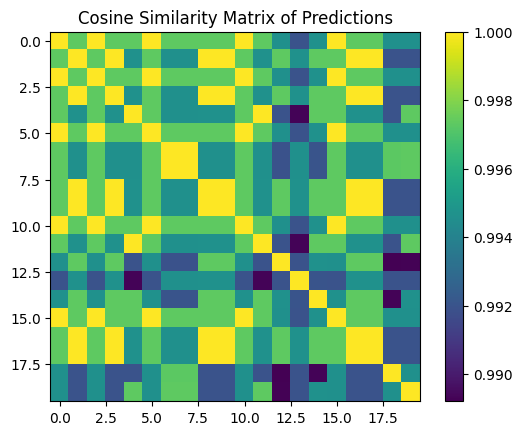

In [4]:
# perform experiment with pertmutations of columns of X_train
import numpy as np
n_experiments = 20
accuracies = []
predictions_list = []
print_every = 1
for i in tqdm(range(n_experiments)):
    X_train_permuted = X_train.copy()
    # changing column order and saving the permutation
    permutation = np.random.permutation(X_train_permuted.shape[1])
    X_train_permuted = X_train_permuted[:, permutation]
    clf = TabPFNClassifier() 
    clf.fit(X_train_permuted, y_train)
    predictions = clf.predict(X_test[:, permutation])
    predictions_list.append(predictions)
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)
    
    if (i + 1) % print_every == 0:
        print(f"Completed {i+1}/{n_experiments} experiments.")
        print(f"Experiment {i+1}, Accuracy: {acc}")
    
print(f"Mean accuracy over {n_experiments} experiments: {np.mean(accuracies)}")
print(f"Std of accuracy over {n_experiments} experiments: {np.std(accuracies)}")
# computing cosinus similarity between predictions of different experiments
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(predictions_list)
print("Cosine similarity matrix between different experiments' predictions:")
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Matrix of Predictions")
plt.show()


 10%|█         | 10/100 [00:02<00:19,  4.53it/s]

Completed 10/100 experiments.
Experiment 10, Accuracy: 0.9859649122807017


 20%|██        | 20/100 [00:04<00:17,  4.70it/s]

Completed 20/100 experiments.
Experiment 20, Accuracy: 0.9894736842105263


 30%|███       | 30/100 [00:06<00:14,  4.72it/s]

Completed 30/100 experiments.
Experiment 30, Accuracy: 0.9824561403508771


 40%|████      | 40/100 [00:08<00:12,  4.66it/s]

Completed 40/100 experiments.
Experiment 40, Accuracy: 0.9859649122807017


 50%|█████     | 50/100 [00:10<00:10,  4.79it/s]

Completed 50/100 experiments.
Experiment 50, Accuracy: 0.9824561403508771


 60%|██████    | 60/100 [00:13<00:09,  4.20it/s]

Completed 60/100 experiments.
Experiment 60, Accuracy: 0.9824561403508771


 70%|███████   | 70/100 [00:15<00:07,  4.17it/s]

Completed 70/100 experiments.
Experiment 70, Accuracy: 0.9824561403508771


 80%|████████  | 80/100 [00:17<00:04,  4.76it/s]

Completed 80/100 experiments.
Experiment 80, Accuracy: 0.9859649122807017


 90%|█████████ | 90/100 [00:19<00:02,  4.59it/s]

Completed 90/100 experiments.
Experiment 90, Accuracy: 0.9824561403508771


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]

Completed 100/100 experiments.
Experiment 100, Accuracy: 0.9789473684210527
Mean accuracy over 100 experiments: 0.9840350877192984
Std of accuracy over 100 experiments: 0.002951334007238702
Cosine similarity matrix between different experiments' predictions:


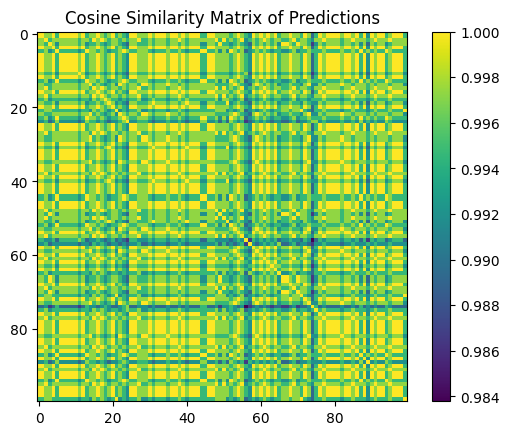

In [5]:
# perform experiment with pertmutations of columns of X_train but for classical ml model
import numpy as np
n_experiments = 100
accuracies = []
predictions_list = []
print_every = 10
for i in tqdm(range(n_experiments)):
    X_train_permuted = X_train.copy()
    # changing column order and saving the permutation
    permutation = np.random.permutation(X_train_permuted.shape[1])
    X_train_permuted = X_train_permuted[:, permutation]
    
    clf.fit(X_train_permuted, y_train)
    predictions = clf.predict(X_test[:, permutation])
    predictions_list.append(predictions)
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)
    
    if (i + 1) % print_every == 0:
        print(f"Completed {i+1}/{n_experiments} experiments.")
        print(f"Experiment {i+1}, Accuracy: {acc}")
    
print(f"Mean accuracy over {n_experiments} experiments: {np.mean(accuracies)}")
print(f"Std of accuracy over {n_experiments} experiments: {np.std(accuracies)}")
# computing cosinus similarity between predictions of different experiments
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(predictions_list)
print("Cosine similarity matrix between different experiments' predictions:")
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Matrix of Predictions")
plt.show()
    


## Experiment on harder datasets from Kaggle

In [6]:
path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")
csv_path = os.path.join(path, [f for f in os.listdir(path) if f.endswith(".csv")][0])

df = pd.read_csv(csv_path)
X = df.drop("exam_score", axis=1).values
y = df["exam_score"].values

# turn y into a classification problem by binning the scores into 3 classes: low (0-40), medium (41-70), high (71-100)
y_binned = pd.cut(y, bins=[-1, 33, 66, 100], labels=[0, 1, 2]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_binned, test_size=0.5, random_state=42)

# Initialize a classifier
clf = TabPFNClassifier()  # Uses TabPFN 2.5 weights, finetuned on real data.
clf.fit(X_train, y_train)

# Predict probabilities
prediction_probabilities = clf.predict_proba(X_test)
# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

# compare with a simple baseline: predict the most frequent class
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_predictions = dummy_clf.predict(X_test)
print("Dummy classifier accuracy", accuracy_score(y_test, dummy_predictions))



Accuracy 0.7865
Dummy classifier accuracy 0.5013


In [ ]:
# perform experiment with pertmutations of columns of X_train
import numpy as np
n_experiments = 20
accuracies = []
predictions_list = []
print_every = 10
for i in tqdm(range(n_experiments)):
    X_train_permuted = X_train.copy()
    # changing column order and saving the permutation
    permutation = np.random.permutation(X_train_permuted.shape[1])
    X_train_permuted = X_train_permuted[:, permutation]
    clf = TabPFNClassifier() 
    clf.fit(X_train_permuted, y_train)
    predictions = clf.predict(X_test[:, permutation])
    predictions_list.append(predictions)
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)
    
    if (i + 1) % print_every == 0:
        print(f"Completed {i+1}/{n_experiments} experiments.")
        print(f"Experiment {i+1}, Accuracy: {acc}")
    
print(f"Mean accuracy over {n_experiments} experiments: {np.mean(accuracies)}")
print(f"Std of accuracy over {n_experiments} experiments: {np.std(accuracies)}")
# computing cosinus similarity between predictions of different experiments
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(predictions_list)
print("Cosine similarity matrix between different experiments' predictions:")
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Matrix of Predictions")
plt.show()
    


 25%|██▌       | 5/20 [00:21<01:03,  4.21s/it]

In [63]:
X_train

array([[1.366e+01, 1.913e+01, 8.946e+01, ..., 1.407e-01, 2.744e-01,
        8.839e-02],
       [1.032e+01, 1.635e+01, 6.531e+01, ..., 2.381e-02, 2.681e-01,
        7.399e-02],
       [1.795e+01, 2.001e+01, 1.142e+02, ..., 1.185e-01, 4.882e-01,
        6.111e-02],
       ...,
       [1.429e+01, 1.682e+01, 9.030e+01, ..., 3.333e-02, 2.458e-01,
        6.120e-02],
       [1.398e+01, 1.962e+01, 9.112e+01, ..., 1.827e-01, 3.179e-01,
        1.055e-01],
       [1.218e+01, 2.052e+01, 7.722e+01, ..., 7.431e-02, 2.694e-01,
        6.878e-02]], shape=(284, 30))

In [64]:
X_train_permuted

array([[1.407e-01, 1.014e+02, 9.657e-02, ..., 8.839e-02, 1.514e+01,
        5.753e+02],
       [2.381e-02, 7.112e+01, 1.012e-02, ..., 7.399e-02, 1.125e+01,
        3.249e+02],
       [1.185e-01, 1.292e+02, 7.293e-02, ..., 6.111e-02, 2.058e+01,
        9.820e+02],
       ...,
       [3.333e-02, 9.444e+01, 7.250e-03, ..., 6.120e-02, 1.491e+01,
        6.326e+02],
       [1.827e-01, 1.139e+02, 1.126e-01, ..., 1.055e-01, 1.704e+01,
        5.995e+02],
       [7.431e-02, 8.458e+01, 2.383e-02, ..., 6.878e-02, 1.334e+01,
        4.587e+02]], shape=(284, 30))

 50%|█████     | 10/20 [00:42<00:42,  4.22s/it]

Completed 10/20 experiments.
Experiment 10, Accuracy: 0.5013


100%|██████████| 20/20 [01:24<00:00,  4.24s/it]

Completed 20/20 experiments.
Experiment 20, Accuracy: 0.5013
Mean accuracy over 20 experiments: 0.50129
Std of accuracy over 20 experiments: 4.358898943540193e-05
Cosine similarity matrix between different experiments' predictions:


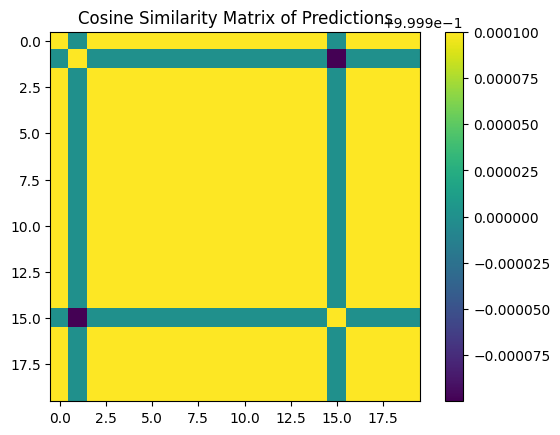

In [ ]:
# perform experiment with pertmutations of rows of X_train
import numpy as np
n_experiments = 20
accuracies = []
predictions_list = []
print_every = 10
for i in tqdm(range(n_experiments)):
    X_train_permuted = X_train.copy()
    # changing column order and saving the permutation
    permutation = np.random.permutation(X_train_permuted.shape[0])
    X_train_permuted = X_train_permuted[permutation, :]
    clf = TabPFNClassifier() 
    clf.fit(X_train_permuted, y_train)
    predictions = clf.predict(X_test)
    predictions_list.append(predictions)
    acc = accuracy_score(y_test, predictions)
    accuracies.append(acc)
    print(f"Experiment {i+1}, Accuracy: {acc}")
    if (i + 1) % print_every == 0:
        print(f"Completed {i+1}/{n_experiments} experiments.")
        
    
print(f"Mean accuracy over {n_experiments} experiments: {np.mean(accuracies)}")
print(f"Std of accuracy over {n_experiments} experiments: {np.std(accuracies)}")
# computing cosinus similarity between predictions of different experiments
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(predictions_list)
print("Cosine similarity matrix between different experiments' predictions:")
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("Cosine Similarity Matrix of Predictions")
plt.show()
    
